In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

C:\Users\Admin\AppData\Local\Temp\ipykernel_16940\1153672462.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Satelli sampling means variance based sampling, but not a good measure for non-uniform distribution. Advantage: just extends series further if you want to increase number of samples
Parallelization of sampling --> batch run (concurrent)

# Added modules

In [2]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

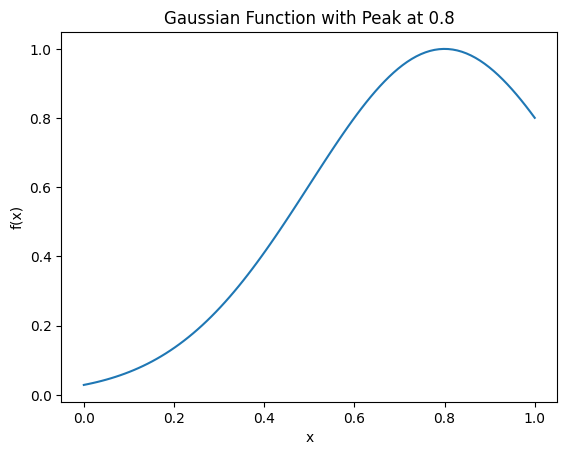

In [3]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.8  # Peak in the middle
sigma = 0.3  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

# You can plot the function to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Gaussian Function with Peak at {mu}')
plt.show()

# Experiment

In [4]:
from model import Schelling
from modules import property_value_from_gdf, update_interested_agents_concurrently, property_value_func_random, utility_func, price_func, income_func, property_value_from_gdf, property_value_quadrants, desirability_func, compute_similar_neighbours, property_value_equal, calculate_gi_star, price_func_cap


def schelling_singapore(num_runs, num_steps, burn_in_period, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density, policy = True):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for run in range(num_runs):
        print('I am in round', run)
        
        # initialize model
        models = Schelling(
            property_value_func=property_value_from_gdf, # quadrants,
            income_func=income_func,
            desirability_func=desirability_func,
            utility_func=utility_func,
            price_func=price_func,
            compute_similar_neighbours=compute_similar_neighbours,
            calculate_gi_star = calculate_gi_star,
            update_interested_agents_func = update_interested_agents_concurrently,
            price_func_cap=price_func_cap,
            policy_singapore=policy,
            #height=20,
            #width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=41)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        # desirability_entropy_std = model_data_entropy['Desirability entropy'].std()
        mean_desirability_entropy = np.mean(np.array(desirability_entropy[burn_in_period::]))
        
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        # agent_entropy_std = model_data_entropy['Agent entropy'].std()
        mean_agent_entropy = np.mean(np.array(agent_entropy[burn_in_period::]))
        print(agent_entropy)
        
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        utility_std = agent_data.groupby(level='Step')['Utility'].std()
        
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    return np.array(overall_desirability_entropy), np.array(overall_agent_entropy), np.array(overall_utility)

In [6]:
# experiment settings
num_iters = 100
burn_in_period = 5
model_steps = 30

# model settings
density = 0.8
minority = 0.3
alpha = 0.5
property_value_weight = 0.1
mu = 0.8
sigma = 0.3

# Run simulation
singapore_policy_effect = schelling_singapore(num_iters, model_steps, burn_in_period, minority, property_value_weight, alpha, mu, sigma, density)

I am in round 0
[       nan 0.84480675 0.78830264 0.80408666 0.79111168 0.82291224
 0.82291224 0.82291224 0.82291224 0.82291224 0.82291224 0.82291224
 0.82291224 0.82291224 0.82291224 0.82291224 0.82291224 0.82291224
 0.82291224 0.82291224 0.82291224 0.82291224 0.82291224 0.82291224
 0.82291224 0.82291224 0.82291224 0.82291224 0.82291224 0.82291224
 0.82291224]
I am in round 1
[       nan 0.84480675 0.84146083 0.84946235 0.8671086  0.81407101
 0.85101483 0.8530354  0.84281302 0.83998233 0.85566069 0.83175504
 0.85626477 0.84055131 0.84802537 0.84055131 0.84514728 0.85527216
 0.84514728 0.84514728 0.84514728 0.84514728 0.84514728 0.84514728
 0.84514728 0.84514728 0.84514728 0.84514728 0.84514728 0.84514728
 0.84514728]
I am in round 2
[       nan 0.84480675 0.80742096 0.79187559 0.72908836 0.73991776
 0.73279629 0.79722841 0.79253621 0.8010615  0.79070757 0.79284742
 0.80117227 0.80117227 0.80117227 0.80399573 0.79605061 0.79778439
 0.78710083 0.79020565 0.79605061 0.79605061 0.79605061

In [7]:
# Save simulation 
singapore_initial_results = np.column_stack((singapore_policy_effect[0], singapore_policy_effect[1], singapore_policy_effect[2]))

# Save the stacked array to a CSV file
np.savetxt('singapore_policy_100_runs_2.csv', singapore_initial_results, delimiter=',', header='desirability_entropy, agent_entropy, utility') 

In [8]:
# experiment settings
num_iters = 100
burn_in_period = 5
model_steps = 30

# model settings
density = 0.8
minority = 0.3
alpha = 0.5
property_value_weight = 0.1
mu = 0.8
sigma = 0.3

# Run simulation
no_policy_effect = schelling_singapore(num_iters, model_steps, burn_in_period, density, minority, alpha, property_value_weight, mu, sigma, policy=False)

I am in round 0
[       nan 0.59303986 0.40398804 0.62000142 0.59077484 0.5031571
 0.52134214 0.55663403 0.57124492 0.56768129 0.60136188 0.50249319
 0.6397092  0.62884741 0.6068305  0.57565789 0.5879358  0.5653453
 0.62931126 0.65488608 0.63732717 0.61262311 0.56702866 0.63467526
 0.6947222  0.58375946 0.57060405 0.63308131 0.61262311 0.60105682
 0.62350133]
I am in round 1
[       nan 0.59303986 0.5260377  0.74742398 0.65581766 0.66655113
 0.64534961 0.60178847 0.63684152 0.71381392 0.62020969 0.53723186
 0.56748421 0.55812446 0.55630107 0.52760461 0.63081484 0.57361627
 0.53342878 0.51679734 0.49943046 0.46675651 0.50084534 0.58213691
 0.52381563 0.5653453  0.56060574 0.5750842  0.61659799 0.60136188
 0.60335644]
I am in round 2


KeyboardInterrupt: 

In [ ]:
no_policy_results = np.column_stack((no_policy_effect[0], no_policy_effect[1], no_policy_effect[2]))

# Save the stacked array to a CSV file
np.savetxt('no_policy_result_100_runs.csv', no_policy_results, delimiter=',', header='desirability_entropy, agent_entropy, utility') 

In [ ]:
import modules as modules
import model as model
from model import Schelling

def schelling_vienna(num_runs, num_steps, burn_in_period, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density, policy = True):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for run in range(num_runs):
        print('I am in round', run)
        
        # initialize model
        models = Schelling(
            property_value_func=modules.property_value_from_gdf, # quadrants,
            income_func=modules.income_func,
            desirability_func=modules.desirability_func,
            utility_func=modules.utility_func,
            price_func=modules.price_func,
            compute_similar_neighbours=modules.compute_similar_neighbours,
            calculate_gi_star = modules.calculate_gi_star,
            update_interested_agents_func = modules.update_interested_agents_concurrently,
            price_func_cap=modules.price_func_cap,
            policy_vienna=policy,
            #height=20,
            #width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=42)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        # desirability_entropy_std = model_data_entropy['Desirability entropy'].std()
        mean_desirability_entropy = np.mean(np.array(desirability_entropy[burn_in_period::]))
        
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        # agent_entropy_std = model_data_entropy['Agent entropy'].std()
        mean_agent_entropy = np.mean(np.array(agent_entropy[burn_in_period::]))
        print(agent_entropy)
        
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        utility_std = agent_data.groupby(level='Step')['Utility'].std()
        
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    return np.array(overall_desirability_entropy), np.array(overall_agent_entropy), np.array(overall_utility)

In [ ]:
# experiment settings
num_iters = 100
burn_in_period = 5
model_steps = 30

# model settings
density = 0.8
minority = 0.3
alpha = 0.5
property_value_weight = 0.1
mu = 0.8
sigma = 0.3

# Run simulation
vienna_policy_effect = schelling_vienna(num_iters, model_steps, burn_in_period, density, minority, alpha, property_value_weight, mu, sigma, policy=True)

In [ ]:
vienna_policy_effect = np.column_stack((vienna_policy_effect[0], vienna_policy_effect[1], vienna_policy_effect[2]))

# Save the stacked array to a CSV file
np.savetxt('vienna_policy_result_100_runs2.csv', vienna_policy_effect, delimiter=',', header='desirability_entropy, agent_entropy, utility') 

# Plots for initial experiment

In [ ]:
singapore_results = pd.read_csv('singapore_policy_100_runs_2.csv')
vienna_results = pd.read_csv('vienna_policy_result_100_runs2.csv')
random_results = pd.read_csv('no_policy_result_100_runs.csv')

In [ ]:
desirability_vienna = vienna_results['# desirability_entropy'].to_numpy()
desirability_singapore = singapore_results['# desirability_entropy'].to_numpy()
desirability_random = random_results['# desirability_entropy'].to_numpy()

agent_vienna = vienna_results[' agent_entropy'].to_numpy()
agent_singapore = singapore_results[' agent_entropy'].to_numpy()
agent_random = random_results[' agent_entropy'].to_numpy()

utility_vienna = vienna_results[' utility'].to_numpy()
utility_singapore = singapore_results[' utility'].to_numpy()
utility_random = random_results[' utility'].to_numpy()

plt.figure(dpi = 300, figsize = (10, 16))

plt.subplot(311)
# Create distribution plots for both datasets
sns.histplot(desirability_vienna, kde=True, color='#63d298ff', label='Policy: Vienna', stat="density")
sns.histplot(desirability_singapore, kde=True, color='#fff176ff', label='Policy: Singapore', stat="density")
sns.histplot(desirability_random, kde=True, color='#ff5252ff', label='no policy', stat="density")

# Customize the plot
plt.title('Desirability: Distribution Plots of different Policies')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.subplot(312)
# Create distribution plots for both datasets
sns.histplot(agent_vienna, kde=True, color='#63d298ff', label='Policy: Vienna', stat="density")
sns.histplot(agent_singapore, kde=True, color='#fff176ff', label='Policy: Singapore', stat="density")
sns.histplot(agent_random, kde=True, color='#ff5252ff', label='no policy', stat="density")

# Customize the plot
plt.title('Agent entropy: Distribution Plots of different Policies')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(313)
# Create distribution plots for both datasets
sns.histplot(utility_vienna, kde=True, color='#63d298ff', label='Policy: Vienna', stat="density")
sns.histplot(utility_singapore, kde=True, color='#fff176ff', label='Policy: Singapore', stat="density")
sns.histplot(utility_random, kde=True, color='#ff5252ff', label='no policy', stat="density")

# Customize the plot
plt.title('Average utility: Distribution Plots of different Policies')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.savefig('Experiment_Results')
plt.show()
plt.close()

# Variations of relevant parameters for experiment